# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the media unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across media units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-media unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Media Unit Agreement

The worker-media unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the media units they have worked on, weighted by the media unit and annotation quality. It calculates how much a worker disagrees with the crowd on a media unit basis. Through the weighted average, media units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), MediaUnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same media units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the media units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a media unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

# How to run the metrics

In [1]:
# Read data

import pandas as pd

pd.set_option('display.max_columns', None)
causal_relations_folder = "crowdflower/output_preliminary"

dataset = pd.read_csv("crowdflower/causal_relations_preliminary.csv")
dataset.head(4)

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,notpossible,relations,events1,events2,index,notpossible_gold,number,pair1,pair2,pair3,pair4,pair5,pair6,relations_gold,sentence1,sentence1_id,sentence2,sentence2_id
0,1303532484,7/16/2017 04:59:46,2704512685,7/16/2017 04:59:20,False,clixsense,0.9735,6576528,CAN,SK,Regina,24.72.133.122,NaN,seized_43_49-r-intercepts_12_22,seized_43_49###intercepts_12_22,seized_43_49###intercepts_12_22,1,NaN,1,"seized_43_49, intercepts_12_22",NaN,NaN,NaN,NaN,NaN,NaN,"INS Sukanya intercepts pirate ships , arms seized",12_10ecbplus.xml_1,"INS Sukanya intercepts pirate ships , arms seized",12_10ecbplus.xml_1
1,1303532484,7/16/2017 06:30:45,2704575927,7/16/2017 06:30:15,False,clixsense,0.9797,24835873,GBR,I2,Manchester,79.76.105.98,NaN,seized_43_49-r-intercepts_12_22,seized_43_49###intercepts_12_22,seized_43_49###intercepts_12_22,1,NaN,1,"seized_43_49, intercepts_12_22",NaN,NaN,NaN,NaN,NaN,NaN,"INS Sukanya intercepts pirate ships , arms seized",12_10ecbplus.xml_1,"INS Sukanya intercepts pirate ships , arms seized",12_10ecbplus.xml_1
2,1303532484,7/16/2017 07:26:16,2704616259,7/16/2017 07:26:00,False,prodege,0.9794,10959404,USA,CA,North Hollywood,108.217.110.26,not related,no_relation,seized_43_49###intercepts_12_22,seized_43_49###intercepts_12_22,1,NaN,1,"seized_43_49, intercepts_12_22",NaN,NaN,NaN,NaN,NaN,NaN,"INS Sukanya intercepts pirate ships , arms seized",12_10ecbplus.xml_1,"INS Sukanya intercepts pirate ships , arms seized",12_10ecbplus.xml_1
3,1303532484,7/16/2017 09:26:58,2704700085,7/16/2017 09:26:35,False,clixsense,0.9750,6524027,USA,PA,West Chester,100.14.57.221,NaN,seized_43_49-r-intercepts_12_22,seized_43_49###intercepts_12_22,seized_43_49###intercepts_12_22,1,NaN,1,"seized_43_49, intercepts_12_22",NaN,NaN,NaN,NaN,NaN,NaN,"INS Sukanya intercepts pirate ships , arms seized",12_10ecbplus.xml_1,"INS Sukanya intercepts pirate ships , arms seized",12_10ecbplus.xml_1


### Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [2]:
import sys
import cProfile
stdout = sys.stdout

sys.path.append('../')

from defaultconfig import Configuration

class CausalRelationsConfig(Configuration):
    inputColumns = ["index", "number", "events1", "sentence1", "sentence1_id", "pair1", "pair2", "pair3", "pair4", "pair5", "pair6"]
    outputColumns = ["relations"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = [
    ]
    
    column_separator = ","
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            #judgments[col] = judgments[col].apply(lambda x: x.replace('no_relation', 'no_causal_relation'))
            judgments[col] = judgments[col].apply(lambda x: x.replace('\n', ','))
        return judgments

config = CausalRelationsConfig()


from controllers.inputController import processFile
cProfile.run('processFile(root=".", directory="", filename="crowdflower/causal_relations_preliminary.csv",config=config)')

pre_processed_results = processFile(
    root=".", directory="", filename="crowdflower/causal_relations_preliminary.csv",
    config=config
)

In [4]:
pre_processed_results

{'annotations':                                                     output.relations
 - 6 . 0_12_19--damage_43_49                                      8.0
 - 6 . 0_12_19-r-quake_20_25                                      4.0
 2004 tsunami_75_87-r-6 . 1 - magnitude quake_0_23                3.0
 3 . 6_96_101--4 . 3_105_110                                      1.0
 3 . 6_96_101--aftershocks_53_64                                  1.0
 3 . 6_96_101--increased_119_128                                  3.0
 3 . 6_96_101--magnitudes_72_82                                   1.0
 3 . 6_96_101--panic_133_138                                     11.0
 3 . 6_96_101--temblor_9_16                                       1.0
 3 . 6_96_101-r-4 . 3_105_110                                     1.0
 3 . 6_96_101-r-aftershocks_53_64                                 5.0
 3 . 6_96_101-r-increased_119_128                                 1.0
 3 . 6_96_101-r-magnitudes_72_82                                  4.0
 3 . 

### Run the metrics

In [4]:
sys.stdout = stdout

# run the metrics
from models import Metrics
cProfile.run('Metrics.run(pre_processed_results, config)')
processed_results = Metrics.run(pre_processed_results, config)

### Plot the unit quality score (UQS) at the beginning of the process and at the end

Text(0,0.5,u'# Units')

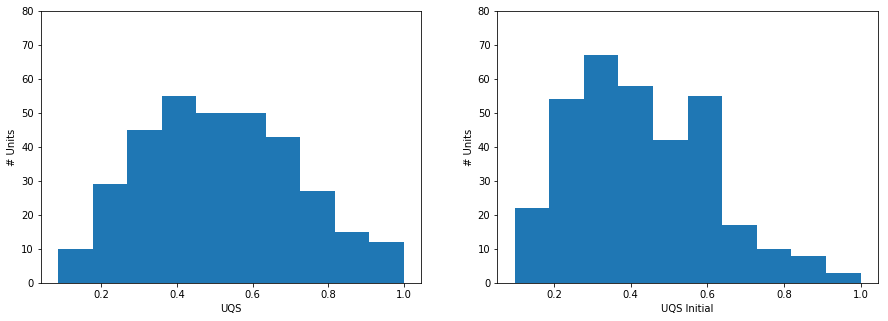

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results["units"]["uqs"])
plt.ylim(0, 80)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(processed_results["units"]["uqs_initial"])
plt.ylim(0, 80)
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

### Plot the change in unit qualtity score at the beginning of the process and at the end

In [5]:
sortUQS = processed_results["units"].sort(['uqs'], ascending=[1])
sortUQS = sortUQS.reset_index()

Text(0.5,0,u'Sentence Index')

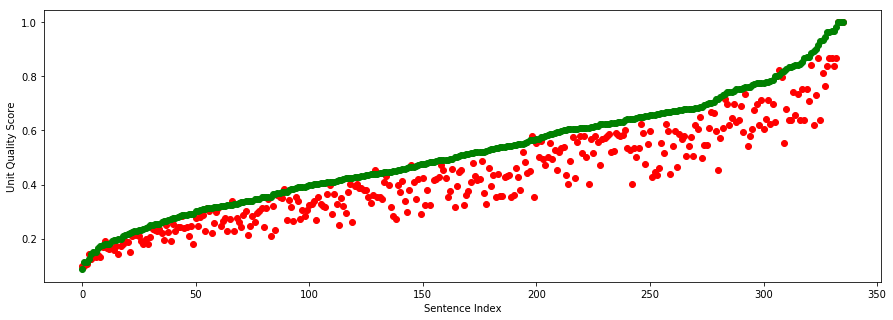

In [6]:
import numpy as np

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')


### Plot the worker quality score (UQS) at the beginning of the process and at the end



In [7]:
processed_results["workers"].head(10)

,worker-cosine,job,output.relations.count,duration,judgment,unit,worker-agreement,spam,wqs,wqs_initial
worker,,,,,,,,,,
1883056,0.316608,1,2.484848,62.666667,33,33,0.376930,False,0.435055,0.337944
1924522,0.502200,1,1.615385,22.692308,13,13,0.294381,False,0.240851,0.166963
2044524,0.632342,1,1.266667,32.433333,30,30,0.248979,False,0.120457,0.103850
3671372,0.364054,1,1.100000,28.600000,10,10,0.404423,False,0.353966,0.279417
4316379,0.443323,1,1.184783,24.858696,92,92,0.321630,False,0.325046,0.216496
5814726,0.180632,1,2.125000,99.687500,16,16,0.504940,False,0.577986,0.487737
5861591,0.143993,1,2.166667,44.666667,6,6,0.487963,False,0.598404,0.514379
6082058,0.514924,1,2.400000,182.400000,15,15,0.210151,False,0.256184,0.147672
6336109,0.234424,1,1.846154,92.717949,39,39,0.462589,False,0.577480,0.419660


Text(0,0.5,u'# Workers')

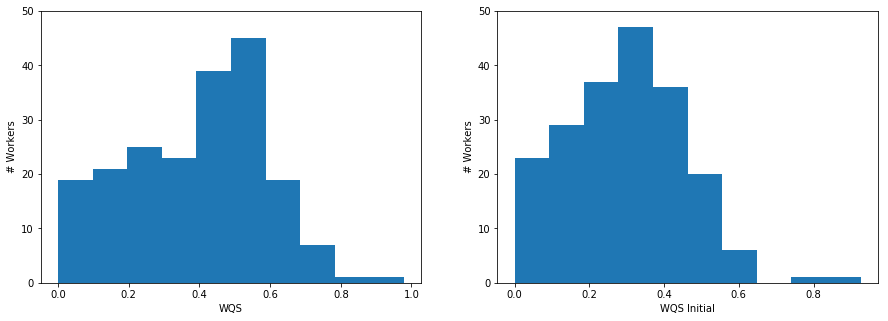

In [8]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results["workers"]["wqs"])
plt.ylim(0, 50)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(processed_results["workers"]["wqs_initial"])
plt.ylim(0, 50)
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

### Plot the change in worker qualtity score at the beginning of the process and at the end


In [9]:
sortWQS = processed_results["workers"].sort(['wqs'], ascending=[1])
sortWQS = sortWQS.reset_index()
sortWQS.head(10)

,worker,worker-cosine,job,output.relations.count,duration,judgment,unit,worker-agreement,spam,wqs,wqs_initial
0,7265244,1.000000,1,2.000000,38.000000,1,1,0.000000,True,0.000000,0.000000
1,40703758,0.960451,1,1.000000,139.250000,4,4,0.018519,False,0.000395,0.001114
2,18969291,0.910913,1,1.000000,6.000000,1,1,0.071429,False,0.001523,0.006363
3,43332393,0.862420,1,1.000000,126.333333,3,3,0.063629,False,0.007333,0.010219
4,25496660,0.728469,1,1.833333,14.666667,6,6,0.080309,False,0.022901,0.038152
5,7348582,0.773866,1,1.000000,50.500000,2,2,0.100000,False,0.029885,0.024229
6,36891115,0.798582,1,1.140351,66.157895,57,57,0.133870,False,0.031100,0.028717
7,28526462,0.781782,1,1.000000,53.000000,1,1,0.142857,False,0.031246,0.031174
8,43611950,0.721797,1,1.800000,22.400000,5,5,0.112098,False,0.038548,0.050231
9,17950689,0.752990,1,1.000000,119.179487,39,39,0.135052,False,0.040883,0.038721


Text(0.5,0,u'Worker Index')

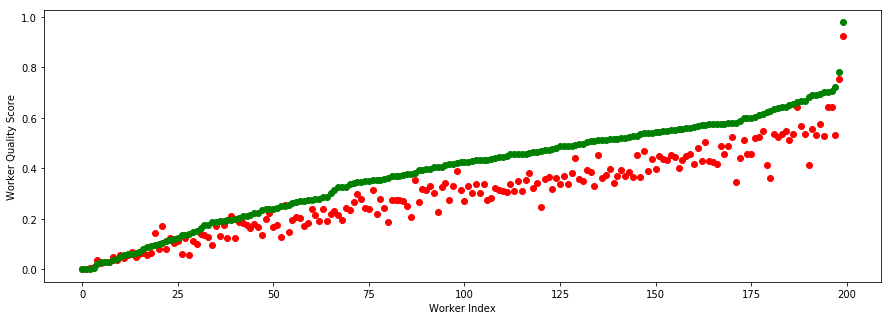

In [10]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')
#plt.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size':12})


In [11]:
sortWQS.to_csv("Results/preliminary_workers_withoutAnnotationQuality.csv", index=False)

In [12]:
sortUQS

,unit,duration,input.events1,input.index,input.number,input.pair1,input.pair2,input.pair3,input.pair4,input.pair5,input.pair6,input.sentence1,input.sentence1_id,job,metrics.avg_annotations,metrics.avg_cos_clarity,metrics.avg_unique_annotations,output.relations,output.relations.annotations,output.relations.cos_clarity,output.relations.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
0,1303753826,148.400000,revealed_47_55###named_106_111###violations_17...,2,64,"revealed_47_55, named_106_111","revealed_47_55, violations_175_185","revealed_47_55, lawsuits_128_136","revealed_47_55, death_29_34","named_106_111, violations_175_185","named_106_111, lawsuits_128_136","In the days following Gray's death , it's been...",19_2ecbplus.xml_13,crowdflower/causal_relations_preliminary,22.0,0.554700,11.0,"{u'named_106_111-r-violations_175_185': 1, u'r...",22,0.554700,11,15,0.085856,{u'named_106_111-r-violations_175_185': 0.0426...,0.097207,{u'named_106_111-r-violations_175_185': 0.0666...
1,1303753837,50.933333,hostile_30_37###control_20_27###broke away_49_...,5,75,"hostile_30_37, control_20_27","hostile_30_37, broke away_49_59","hostile_30_37, vigil_84_89","hostile_30_37, struggled_7_16","hostile_30_37, killed_122_128","control_20_27, broke away_49_59",Police struggled to control a hostile crowd th...,19_3ecbplus.xml_8,crowdflower/causal_relations_preliminary,30.0,0.447214,13.0,"{u'hostile_30_37-r-control_20_27': 1, u'hostil...",30,0.447214,13,15,0.112689,{u'hostile_30_37-r-control_20_27': 0.022827909...,0.099222,{u'hostile_30_37-r-control_20_27': 0.066666666...
2,1303753898,55.133333,wounded_50_57###Memorial_0_8###creating_210_21...,4,97,"clashed_170_177, ugly_136_140","clashed_170_177, turned_129_135","melee_221_226, tossing_190_197","melee_221_226, pointing_93_101","melee_221_226, ugly_136_140","melee_221_226, turned_129_135","Memorial for Kimani 'Kiki' Gray , who was fata...",19_5ecbplus.xml_2,crowdflower/causal_relations_preliminary,23.0,0.397360,11.0,"{u'no_relation': 3, u'melee_221_226-r-ugly_136...",23,0.397360,11,15,0.113879,"{u'no_relation': 0.217913994993, u'melee_221_2...",0.106782,"{u'no_relation': 0.2, u'melee_221_226-r-ugly_1..."
3,1303753899,85.200000,wounded_50_57###Memorial_0_8###creating_210_21...,4,98,"tossing_190_197, pointing_93_101","tossing_190_197, ugly_136_140","tossing_190_197, turned_129_135","pointing_93_101, ugly_136_140","pointing_93_101, turned_129_135","ugly_136_140, turned_129_135","Memorial for Kimani 'Kiki' Gray , who was fata...",19_5ecbplus.xml_2,crowdflower/causal_relations_preliminary,28.0,0.521286,10.0,"{u'ugly_136_140-r-turned_129_135': 4, u'no_rel...",28,0.521286,10,15,0.123332,{u'ugly_136_140-r-turned_129_135': 0.231293836...,0.144652,{u'ugly_136_140-r-turned_129_135': 0.266666666...
4,1303753803,45.933333,conducted_53_62###patrol_105_111###mission_112...,1,41,"conducted_53_62, patrol_105_111","conducted_53_62, mission_112_119","conducted_53_62, operation_43_52","patrol_105_111, mission_112_119","patrol_105_111, operation_43_52","mission_112_119, operation_43_52",This is the fifth successful anti - piracy ope...,12_9ecbplus.xml_12,crowdflower/causal_relations_preliminary,30.0,0.436436,13.0,"{u'conducted_53_62-r-patrol_105_111': 4, u'pat...",30,0.436436,13,15,0.144450,{u'conducted_53_62-r-patrol_105_111': 0.303310...,0.123893,{u'conducted_53_62-r-patrol_105_111': 0.266666...
5,1303753896,55.400000,wounded_50_57###Memorial_0_8###creating_210_21...,4,95,"Memorial_0_8, pointing_93_101","Memorial_0_8, ugly_136_140","Memorial_0_8, turned_129_135","creating_210_218, clashed_170_177","creating_210_218, melee_221_226","creating_210_218, tossing_190_197","Memorial for Kimani 'Kiki' Gray , who was fata...",19_5ecbplus.xml_2,crowdflower/causal_relations_preliminary,26.0,0.431331,10.0,"{u'creating_210_218-r-melee_221_226': 1, u'cre...",26,0.431331,10,15,0.151447,{u'creating_210_218-r-melee_221_226': 0.090592...,0.147826,{u'creating_210_218-r-melee_221_226': 0.066666..

In [14]:
rows = []
header = list(sortUQS)
header.extend(["event-event_pair", "no_of_annotations", "event-event_pair_final_score", "event-event_pair_initial_score"])

rows.append(header)

for i in range(len(sortUQS.index)):
    keys = []
    if (str(sortUQS["input.pair1"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair1"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair1"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair2"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair2"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair2"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair3"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair3"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair3"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair4"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair4"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair4"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair5"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair5"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair5"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair6"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair6"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair6"].iloc[i]).replace(', ', '-r-'))
    keys.append("no_relation")
    
    for j in range(len(keys)):
        row = list(sortUQS.iloc[i])
        row.append(keys[j])
        #if (keys[j] not in sortUQS["output.relations"].iloc[i]):
        #    print(keys[j])
        row.append(sortUQS["output.relations"].iloc[i][keys[j]])
        row.append(sortUQS["unit_annotation_score"].iloc[i][keys[j]])
        row.append(sortUQS["unit_annotation_score_initial"].iloc[i][keys[j]])
    
        rows.append(row)

In [15]:
import csv

with open('Results/preliminary_annotations_withoutAnnotationQuality.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)
    

# Adding the annotation quality 

## Event Tokens without Offsets

In [5]:
# extract the annotation vector components

import pandas as pd

crowd_noOffset = pd.read_csv("crowdflower/causal_relations_preliminary_noOffset.csv")
annotations = list(pd.concat([crowd_noOffset['pair1_noOffset'], crowd_noOffset['pair2_noOffset'], 
                         crowd_noOffset['pair3_noOffset'], crowd_noOffset['pair4_noOffset'], 
                         crowd_noOffset['pair5_noOffset'], crowd_noOffset['pair6_noOffset']]).unique())

cleanedList = [x for x in annotations if pd.isnull(x) != True]

final_vector = []
for item in cleanedList:
    final_vector.append(item.replace(', ', '--'))
    final_vector.append(item.replace(', ', '-r-'))
final_vector.append('no_relation')  

len(final_vector)


2151

In [6]:
import sys
sys.path.append('../')
stdout = sys.stdout

from defaultconfig import Configuration

class CausalRelationsConfig(Configuration):
    inputColumns = ["index", "number", "events1", "sentence1", "sentence1_id", "pair1", "pair2", "pair3", "pair4", "pair5", "pair6", "pair1_noOffset", "pair2_noOffset", "pair3_noOffset", "pair4_noOffset", "pair5_noOffset", "pair6_noOffset", "relations"]
    outputColumns = ["relations_noOffset"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = final_vector
    
    column_separator = ","
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            #judgments[col] = judgments[col].apply(lambda x: x.replace('no_relation', 'no_causal_relation'))
            judgments[col] = judgments[col].apply(lambda x: x.replace('\n', ','))
        return judgments

config = CausalRelationsConfig()

In [7]:
from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename="crowdflower/causal_relations_preliminary_noOffset.csv",
    config=config
)

In [ ]:
cProfile.run('processFile(root=".", directory="", filename="crowdflower/causal_relations_preliminary_noOffset.csv",config=config)')



In [19]:
sys.stdout = stdout
# run the metrics 
from models import Metrics
processed_results_noOffsets = Metrics.run(pre_processed_results, config)

1 iterations; max d= 1.0 ; wqs d= 0.698169194452; sqs d= 0.568332483248; rqs d= 0.608944466771
2 iterations; max d= 0.9999 ; wqs d= 0.165328102473; sqs d= 0.137306455148; rqs d= 0.0317528161571
3 iterations; max d= 0.0722951527269 ; wqs d= 0.0105919374327; sqs d= 0.00796583346768; rqs d= 0.00426747026095
4 iterations; max d= 0.024192160758 ; wqs d= 0.00288770386996; sqs d= 0.00505682884783; rqs d= 0.00177330555862
5 iterations; max d= 0.00660835180966 ; wqs d= 0.000802687421936; sqs d= 0.000555260964185; rqs d= 0.000227342979149
6 iterations; max d= 0.00191470454639 ; wqs d= 0.000234410951669; sqs d= 0.00036486391491; rqs d= 0.000125145265556
7 iterations; max d= 0.000754835309407 ; wqs d= 7.65505523147e-05; sqs d= 4.98241592738e-05; rqs d= 1.83318867573e-05


Text(0,0.5,u'# Units')

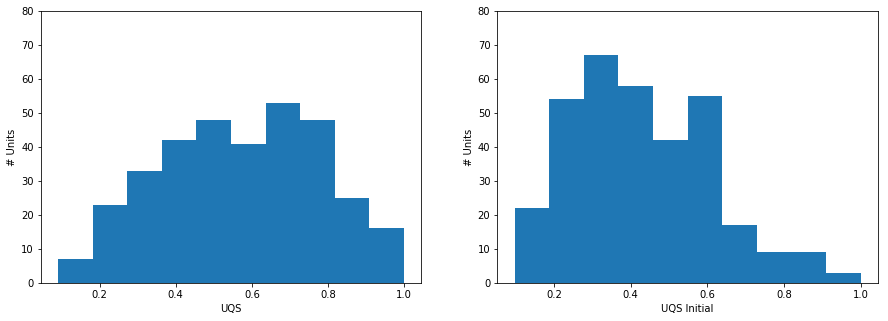

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results_noOffsets["units"]["uqs"])
plt.ylim(0, 80)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(processed_results_noOffsets["units"]["uqs_initial"])
plt.ylim(0, 80)
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

Text(0.5,0,u'Sentence Index')

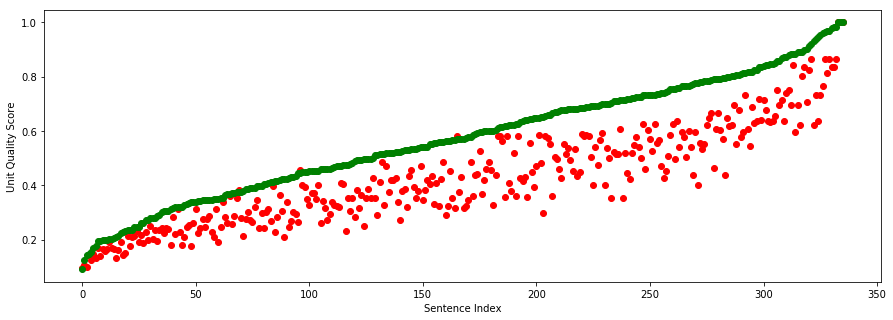

In [21]:
sortUQS_noOffset = processed_results_noOffsets["units"].sort(['uqs'], ascending=[1])
sortUQS_noOffset = sortUQS_noOffset.reset_index()

import numpy as np

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortUQS_noOffset.shape[0]), sortUQS_noOffset["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS_noOffset.shape[0]), sortUQS_noOffset["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')

Text(0,0.5,u'# Workers')

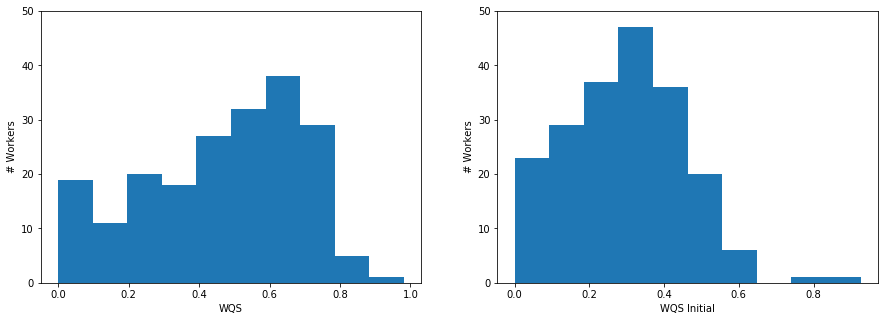

In [22]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results_noOffsets["workers"]["wqs"])
plt.ylim(0, 50)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(processed_results_noOffsets["workers"]["wqs_initial"])
plt.ylim(0, 50)
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

Text(0.5,0,u'Worker Index')

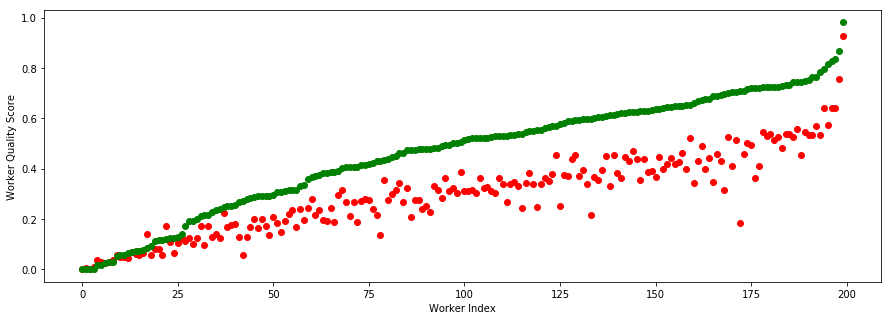

In [37]:
sortWQS_noOffset = processed_results_noOffsets["workers"].sort(['wqs'], ascending=[1])
sortWQS_noOffset = sortWQS_noOffset.reset_index()

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS_noOffset.shape[0]), sortWQS_noOffset["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS_noOffset.shape[0]), sortWQS_noOffset["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')

In [39]:
sortWQS_noOffset.to_csv("Results/preliminary_workers_withAnnotationQuality_noOffsets.csv", index=False)

In [27]:
rows = []
header = list(sortUQS_noOffset)
header.extend(["event-event_pair", "no_of_annotations", "event-event_pair_final_score", "event-event_pair_initial_score"])

remove_indices = [17, 24,30,32]
header = [i for j, i in enumerate(header) if j not in remove_indices]

rows.append(header)

for i in range(len(sortUQS_noOffset.index)):
    keys = []
    if (str(sortUQS_noOffset["input.pair1_noOffset"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_noOffset["input.pair1_noOffset"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_noOffset["input.pair1_noOffset"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_noOffset["input.pair2_noOffset"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_noOffset["input.pair2_noOffset"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_noOffset["input.pair2_noOffset"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_noOffset["input.pair3_noOffset"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_noOffset["input.pair3_noOffset"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_noOffset["input.pair3_noOffset"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_noOffset["input.pair4_noOffset"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_noOffset["input.pair4_noOffset"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_noOffset["input.pair4_noOffset"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_noOffset["input.pair5_noOffset"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_noOffset["input.pair5_noOffset"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_noOffset["input.pair5_noOffset"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_noOffset["input.pair6_noOffset"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_noOffset["input.pair6_noOffset"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_noOffset["input.pair6_noOffset"].iloc[i]).replace(', ', '-r-'))
    keys.append("no_relation")
    
    
    for j in range(len(keys)):
        #print(keys[j])
        row = list(sortUQS_noOffset.iloc[i])
        newRow = [k for l, k in enumerate(row) if l not in remove_indices]
        newRow.append(keys[j])
        if (keys[j] not in sortUQS_noOffset["output.relations_noOffset"].iloc[i]):
            print(keys[j])
        newRow.append(sortUQS_noOffset["output.relations_noOffset"].iloc[i][keys[j]])
        newRow.append(sortUQS_noOffset["unit_annotation_score"].iloc[i][keys[j]])
        newRow.append(sortUQS_noOffset["unit_annotation_score_initial"].iloc[i][keys[j]])
    
        rows.append(newRow)

In [28]:
import csv

with open('Results/preliminary_annotations_withAnnotationQuality_noOffsets.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)
    

## Event Tokens without Offsets

In [1]:
# extract the annotation vector components

import pandas as pd

crowd_noOffset = pd.read_csv("crowdflower/causal_relations_preliminary_noOffset_lemma.csv")
annotations = list(pd.concat([crowd_noOffset['pair1_lemma'], crowd_noOffset['pair2_lemma'], 
                         crowd_noOffset['pair3_lemma'], crowd_noOffset['pair4_lemma'], 
                         crowd_noOffset['pair5_lemma'], crowd_noOffset['pair6_lemma']]).unique())

cleanedList = [x for x in annotations if pd.isnull(x) != True]

final_vector = []
for item in cleanedList:
    final_vector.append(item.replace(', ', '--'))
    final_vector.append(item.replace(', ', '-r-'))
final_vector.append('no_relation')  

len(final_vector)



2003

In [2]:
import sys
sys.path.append('../')
stdout = sys.stdout

from defaultconfig import Configuration

class CausalRelationsConfig(Configuration):
    inputColumns = ["index", "number", "events1", "sentence1", "sentence1_id", "pair1", "pair2", "pair3", "pair4", "pair5", "pair6", "pair1_noOffset", "pair2_noOffset", "pair3_noOffset", "pair4_noOffset", "pair5_noOffset", "pair6_noOffset", "relations", "pair1_lemma", "pair2_lemma", "pair3_lemma", "pair4_lemma", "pair5_lemma", "pair6_lemma", "relations_noOffset"]
    outputColumns = ["relations_lemma"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = final_vector
    
    column_separator = ","
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            #judgments[col] = judgments[col].apply(lambda x: x.replace('no_relation', 'no_causal_relation'))
            judgments[col] = judgments[col].apply(lambda x: x.replace('\n', ','))
        return judgments

config = CausalRelationsConfig()

In [3]:
from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename="crowdflower/causal_relations_preliminary_noOffset_lemma.csv",
    config=config
)

1 iterations; max d= 1.0 ; wqs d= 0.698169194452; sqs d= 0.568332483248; rqs d= 0.616993158758
2 iterations; max d= 0.9999 ; wqs d= 0.163511288009; sqs d= 0.13570712105; rqs d= 0.0316493894086
3 iterations; max d= 0.0721583442152 ; wqs d= 0.0105046106184; sqs d= 0.00791122486429; rqs d= 0.00431912121315
4 iterations; max d= 0.0266421756494 ; wqs d= 0.0028694060201; sqs d= 0.00496866436998; rqs d= 0.00175142829577
5 iterations; max d= 0.00640345126419 ; wqs d= 0.000789866940155; sqs d= 0.000544591227567; rqs d= 0.000223065940595
6 iterations; max d= 0.00192293519382 ; wqs d= 0.000221549484475; sqs d= 0.000348932640284; rqs d= 0.000121456183439
7 iterations; max d= 0.000721384560806 ; wqs d= 7.60370308634e-05; sqs d= 4.83645117395e-05; rqs d= 1.76049327831e-05


In [6]:
sys.stdout = stdout
# run the metrics 
from models import Metrics
processed_results_lemma = Metrics.run(pre_processed_results, config)

In [8]:
list(processed_results_lemma["units"])

['duration',
 'input.events1',
 'input.index',
 'input.number',
 'input.pair1',
 'input.pair1_lemma',
 'input.pair1_noOffset',
 'input.pair2',
 'input.pair2_lemma',
 'input.pair2_noOffset',
 'input.pair3',
 'input.pair3_lemma',
 'input.pair3_noOffset',
 'input.pair4',
 'input.pair4_lemma',
 'input.pair4_noOffset',
 'input.pair5',
 'input.pair5_lemma',
 'input.pair5_noOffset',
 'input.pair6',
 'input.pair6_lemma',
 'input.pair6_noOffset',
 'input.relations',
 'input.relations_noOffset',
 'input.sentence1',
 'input.sentence1_id',
 'job',
 'output.relations_lemma',
 'output.relations_lemma.annotations',
 'output.relations_lemma.unique_annotations',
 'worker',
 'uqs',
 'unit_annotation_score',
 'uqs_initial',
 'unit_annotation_score_initial']

Text(0,0.5,u'# Units')

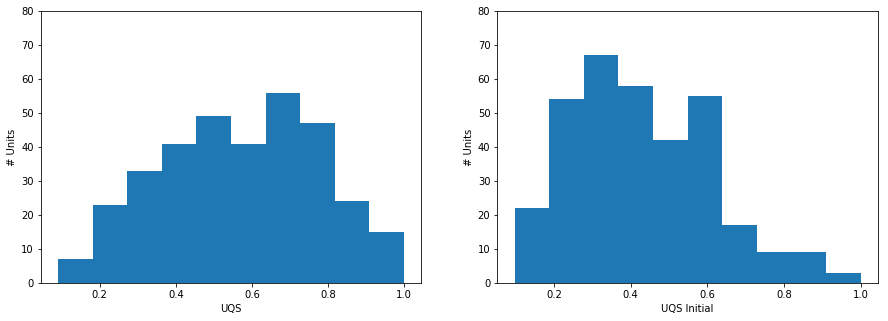

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results_lemma["units"]["uqs"])
plt.ylim(0, 80)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(processed_results_lemma["units"]["uqs_initial"])
plt.ylim(0, 80)
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

Text(0.5,0,u'Sentence Index')

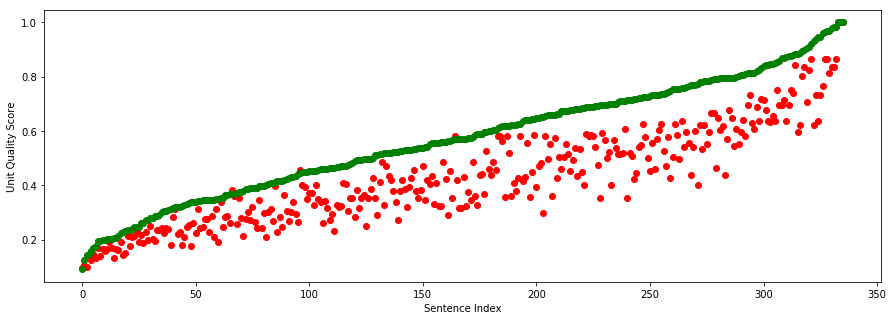

In [35]:
sortUQS_lemma = processed_results_lemma["units"].sort(['uqs'], ascending=[1])
sortUQS_lemma = sortUQS_lemma.reset_index()

import numpy as np

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortUQS_lemma.shape[0]), sortUQS_lemma["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS_lemma.shape[0]), sortUQS_lemma["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')

Text(0,0.5,u'# Workers')

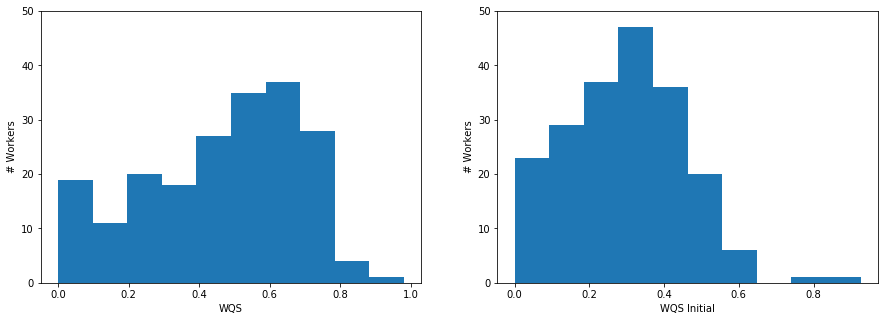

In [36]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results_lemma["workers"]["wqs"])
plt.ylim(0, 50)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(processed_results_lemma["workers"]["wqs_initial"])
plt.ylim(0, 50)
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

Text(0.5,0,u'Worker Index')

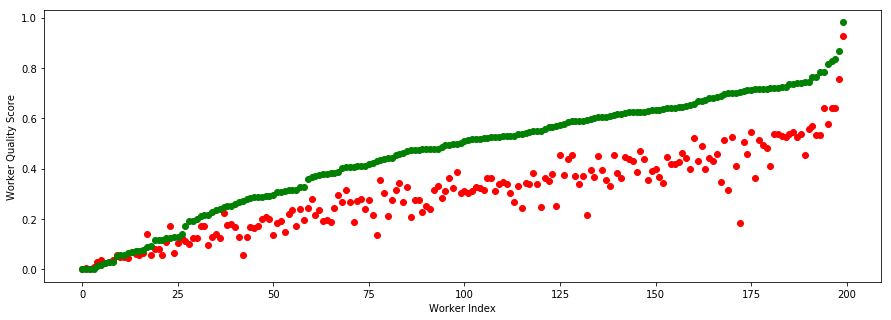

In [38]:
sortWQS_lemma = processed_results_lemma["workers"].sort(['wqs'], ascending=[1])
sortWQS_lemma = sortWQS_lemma.reset_index()

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS_lemma.shape[0]), sortWQS_lemma["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS_lemma.shape[0]), sortWQS_lemma["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')

In [40]:
sortWQS_lemma.to_csv("Results/preliminary_workers_withAnnotationQuality_lemma.csv", index=False)

In [42]:
sortUQS_lemma

,unit,duration,input.events1,input.index,input.number,input.pair1,input.pair1_lemma,input.pair1_noOffset,input.pair2,input.pair2_lemma,input.pair2_noOffset,input.pair3,input.pair3_lemma,input.pair3_noOffset,input.pair4,input.pair4_lemma,input.pair4_noOffset,input.pair5,input.pair5_lemma,input.pair5_noOffset,input.pair6,input.pair6_lemma,input.pair6_noOffset,input.relations,input.relations_noOffset,input.sentence1,input.sentence1_id,job,metrics.avg_annotations,metrics.avg_cos_clarity,metrics.avg_unique_annotations,output.relations_lemma,output.relations_lemma.annotations,output.relations_lemma.cos_clarity,output.relations_lemma.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
0,1303753826,148.400000,revealed_47_55###named_106_111###violations_17...,2,64,"revealed_47_55, named_106_111","name, reveal","named, revealed","revealed_47_55, violations_175_185","reveal, violation","revealed, violations","revealed_47_55, lawsuits_128_136","lawsuit, reveal","lawsuits, revealed","revealed_47_55, death_29_34","death, reveal","death, revealed","named_106_111, violations_175_185","name, violation","named, violations","named_106_111, lawsuits_128_136","lawsuit, name","lawsuits, named",revealed_47_55-r-violations_175_185,revealed-r-violations,"In the days following Gray's death , it's been...",19_2ecbplus.xml_13,crowdflower/causal_relations_preliminary_noOff...,22.0,0.554700,11.0,"{u'conduct--mission': 0, u'dead-r-declare': 0,...",22,0.554700,11,15,0.090752,"{u'conduct--mission': 0.0, u'dead-r-declare': ...",0.097207,"{u'conduct--mission': 0.0, u'dead-r-declare': ..."
1,1303753898,55.133333,wounded_50_57###Memorial_0_8###creating_210_21...,4,97,"clashed_170_177, ugly_136_140","clash, ugly","clashed, ugly","clashed_170_177, turned_129_135","clash, turn","clashed, turned","melee_221_226, tossing_190_197","melee, toss","melee, tossing","melee_221_226, pointing_93_101","melee, point","melee, pointing","melee_221_226, ugly_136_140","melee, ugly","melee, ugly","melee_221_226, turned_129_135","melee, turn","melee, turned",melee_221_226-r-pointing_93_101,melee-r-pointing,"Memorial for Kimani 'Kiki' Gray , who was fata...",19_5ecbplus.xml_2,crowdflower/causal_relations_preliminary_noOff...,23.0,0.397360,11.0,"{u'conduct--mission': 0, u'dead-r-declare': 0,...",23,0.397360,11,15,0.126306,"{u'conduct--mission': 0.0, u'dead-r-declare': ...",0.106782,"{u'conduct--mission': 0.0, u'dead-r-declare': ..."
2,1303753837,50.933333,hostile_30_37###control_20_27###broke away_49_...,5,75,"hostile_30_37, control_20_27","control, hostile","control, hostile","hostile_30_37, broke away_49_59","break away, hostile","broke away, hostile","hostile_30_37, vigil_84_89","hostile, vigil","hostile, vigil","hostile_30_37, struggled_7_16","hostile, struggle","hostile, struggled","hostile_30_37, killed_122_128","hostile, kill","hostile, killed","control_20_27, broke away_49_59","break away, control","broke away, control",hostile_30_37-r-killed_122_128,hostile-r-killed,Police struggled to control a hostile crowd th...,19_3ecbplus.xml_8,crowdflower/causal_relations_preliminary_noOff...,30.0,0.447214,13.0,"{u'conduct--mission': 0, u'dead-r-declare': 0,...",30,0.447214,13,15,0.143631,"{u'conduct--mission': 0.0, u'dead-r-declare': ...",0.099222,"{u'conduct--mission': 0.0, u'dead-r-declare': ..."
3,1303753899,85.200000,wounded_50_57###Memorial_0_8###creating_210_21...,4,98,"tossing_190_197, pointing_93_101","point, toss","pointing, tossing","tossing_190_197, ugly_136_140","toss, ugly","tossing, ugly","tossing_190_197, turned_129_135","toss, turn","tossing, turned","pointing_93_101, ugly_136_140","point, ugly","pointing, ugly","pointing_93_101, turned_129_135","point, turn","pointing, turned","ugly_136_140, turned_129_135","turn, ugly","turned, ugly",tossing_190_197-r-pointing_93_101\npointing_93...,pointing--tossing\npointing--ugly,"Memorial for Kimani 'Kiki' Gray , who was fata...",19_5ecbplus.xml_2,crowdflower/causal_relations_preliminary_no

In [44]:
sortUQS_lemma.columns

Index([u'unit', u'duration', u'input.events1', u'input.index', u'input.number',
       u'input.pair1', u'input.pair1_lemma', u'input.pair1_noOffset',
       u'input.pair2', u'input.pair2_lemma', u'input.pair2_noOffset',
       u'input.pair3', u'input.pair3_lemma', u'input.pair3_noOffset',
       u'input.pair4', u'input.pair4_lemma', u'input.pair4_noOffset',
       u'input.pair5', u'input.pair5_lemma', u'input.pair5_noOffset',
       u'input.pair6', u'input.pair6_lemma', u'input.pair6_noOffset',
       u'input.relations', u'input.relations_noOffset', u'input.sentence1',
       u'input.sentence1_id', u'job', u'metrics.avg_annotations',
       u'metrics.avg_cos_clarity', u'metrics.avg_unique_annotations',
       u'output.relations_lemma', u'output.relations_lemma.annotations',
       u'output.relations_lemma.cos_clarity',
       u'output.relations_lemma.unique_annotations', u'worker', u'uqs',
       u'unit_annotation_score', u'uqs_initial',
       u'unit_annotation_score_initial'],
      

In [46]:
rows = []
header = list(sortUQS_lemma)
header.extend(["event-event_pair", "no_of_annotations", "event-event_pair_final_score", "event-event_pair_initial_score"])

remove_indices = [31, 37, 39]
header = [i for j, i in enumerate(header) if j not in remove_indices]

rows.append(header)

for i in range(len(sortUQS_lemma.index)):
    keys = []
    if (str(sortUQS_lemma["input.pair1_lemma"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_lemma["input.pair1_lemma"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_lemma["input.pair1_lemma"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_lemma["input.pair2_lemma"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_lemma["input.pair2_lemma"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_lemma["input.pair2_lemma"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_lemma["input.pair3_lemma"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_lemma["input.pair3_lemma"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_lemma["input.pair3_lemma"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_lemma["input.pair4_lemma"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_lemma["input.pair4_lemma"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_lemma["input.pair4_lemma"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_lemma["input.pair5_lemma"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_lemma["input.pair5_lemma"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_lemma["input.pair5_lemma"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS_lemma["input.pair6_lemma"].iloc[i]) != "nan"):
        keys.append(str(sortUQS_lemma["input.pair6_lemma"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS_lemma["input.pair6_lemma"].iloc[i]).replace(', ', '-r-'))
    keys.append("no_relation")
    
    
    for j in range(len(keys)):
        #print(keys[j])
        row = list(sortUQS_lemma.iloc[i])
        newRow = [k for l, k in enumerate(row) if l not in remove_indices]
        newRow.append(keys[j])
        if (keys[j] not in sortUQS_lemma["output.relations_lemma"].iloc[i]):
            print(keys[j])
        newRow.append(sortUQS_lemma["output.relations_lemma"].iloc[i][keys[j]])
        newRow.append(sortUQS_lemma["unit_annotation_score"].iloc[i][keys[j]])
        newRow.append(sortUQS_lemma["unit_annotation_score_initial"].iloc[i][keys[j]])
    
        rows.append(newRow)

In [47]:
import csv

with open('Results/preliminary_annotations_withAnnotationQuality_lemma.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)